# 经销商订单执行物流最优成本规划-上

解决这个问题总体的思路是：先不考虑限制条件，找出成本最优的发送模式，然后再考虑相关限制条件，并尽量使成本更低。
求解最优成本的发送模式的具体方法是：将各个工厂，仓库，经销商看作点，工厂到仓库，仓库到经销商，工厂到经销商为有向边，建立有向图，并且将运输费用作为边的权重，那么求解成本最低的问题就转化为求解有向图中的总权重最小的最优路径的求解。

In [2]:
import numpy as np 
import pandas as pd 
import os

In [28]:
data = pd.read_csv('C:/ML/path.csv')

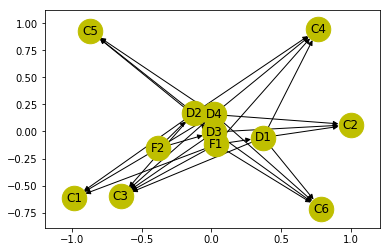

In [31]:
import networkx as nx
%matplotlib inline
FG = nx.DiGraph()
FG = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,create_using=nx.DiGraph())

FG.nodes()
FG.edges()
nx.draw_networkx(FG, with_labels=True,node_size=600, node_color='y') 

In [45]:
#若从F1工厂发出
path1={}
for i in range(1,7):
    path1['C'+str(i)]=nx.dijkstra_path(FG, source='F1', target="C"+str(i), weight='cost')
path1

{'C1': ['F1', 'C1'],
 'C2': ['F1', 'D2', 'C2'],
 'C3': ['F1', 'D4', 'C3'],
 'C4': ['F1', 'D2', 'C4'],
 'C5': ['F1', 'D4', 'C5'],
 'C6': ['F1', 'C6']}

In [50]:
#若从F2工厂发出
path2={}
for i in range(1,7):
    path2['C'+str(i)]=nx.dijkstra_path(FG, source='F2', target="C"+str(i), weight='cost')
path2

{'C1': ['F2', 'D2', 'C1'],
 'C2': ['F2', 'D2', 'C2'],
 'C3': ['F2', 'D4', 'C3'],
 'C4': ['F2', 'D2', 'C4'],
 'C5': ['F2', 'D4', 'C5'],
 'C6': ['F2', 'D4', 'C6']}

当不考虑仓库的吞吐量时，计算最优总的费用：

In [57]:
#从F1发出时，到达各客户最优费用
import collections
origin=data['origin']
dest=data['dest']
weight=data['cost']
fee=collections.defaultdict(dict)
best_fee1=collections.defaultdict(int)
for i in range(len(origin)):
    fee[origin[i]][dest[i]]=weight[i]
for i in range(1,7):
    sig=path1['C'+str(i)]
    length=len(sig)
    for j in range(length-1):
        best_fee1['C'+str(i)]+=fee[sig[j]][sig[j+1]]
best_fee1

defaultdict(int,
            {'C1': 1.0,
             'C2': 1.0,
             'C3': 0.40000000000000002,
             'C4': 1.5,
             'C5': 0.69999999999999996,
             'C6': 1.0})

In [58]:
#从F2发出时，到达各客户最优费用
best_fee2=collections.defaultdict(int)
for i in range(len(origin)):
    fee[origin[i]][dest[i]]=weight[i]
for i in range(1,7):
    sig=path2['C'+str(i)]
    length=len(sig)
    for j in range(length-1):
        best_fee2['C'+str(i)]+=fee[sig[j]][sig[j+1]]
best_fee2

defaultdict(int,
            {'C1': 1.3,
             'C2': 0.80000000000000004,
             'C3': 0.40000000000000002,
             'C4': 1.3,
             'C5': 0.69999999999999996,
             'C6': 1.7})

In [60]:
fee_diff=collections.defaultdict(int)
for i in range(1,7):
    fee_diff['C'+str(i)]=best_fee1['C'+str(i)]-best_fee2['C'+str(i)]
fee_diff


defaultdict(int,
            {'C1': -0.30000000000000004,
             'C2': 0.19999999999999996,
             'C3': 0.0,
             'C4': 0.19999999999999996,
             'C5': 0.0,
             'C6': -0.69999999999999996})

由以上的最优费用差值对比，我们可以看到，在生产量足够时，我们优先满足两个工厂中到达消费者费用差值大的，因为假如由于供应不足而导致运往消费者的出发点不能选择最优的那个的时候，差值越大意味着造成的损失也越大。因而我们满足最优到达消费者的费用优先顺序为：C6，C1，C2，C4，C3,C5
那么运输方案为：F1-C6 20000吨；F1-C1 50000吨；F2-D2-C2 10000吨；F2-D2-C4 35000吨；从F1和F2出发到达C3或C5的费用相同，因而取F1或F2都可以，再考虑仓库吞吐量与F1，F2仓库的剩余存储量，发现F1剩余存储量不够，F2足够；而对于吞吐量，由于最优路径经过的仓库相同，因而剩下的方案可以是F1-D4-C3 40000吨；F1-D4-C5 40000吨；F2-D4-C5 20000吨 或者是 F2-D4-C3 40000吨；F2-D4-C5 60000吨


这种理想情况下可以得到最优的费用为：181500元

但是在这种情况下，D2，D4仓库的吞吐量超过了最大吞吐量，我们需要改进我们的方案，调整运往C2或C4，以及运往C3或C5的路径

# 我们需要采用什么样的发运模式来达到总物流成本最低？

经过上面的分析，我们可以发现，对于C2-C5，当不考虑仓库吞吐量，工厂面积时，采用经过特定仓库中转，再发往经销商的发送模式，对C1-C6采用直接由工厂发往经销商的发送模式，总物流成本最低。

优化方案：考虑次优路径

考虑不经过D2，D4时，达到各消费者的次优的路径